In [1]:
# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

# Careful with these: basic_viewing should be replaced soon
from basic_viewing import events as evt
# from basic_viewing.structure import kwik_functions as kwkf
# from basic_viewing.structure.core import h5_functions as kwdf

from bci.core import kwik_functions as kwkf
from bci.core.file import h5_functions as kwdf 
from bci.core import expstruct as et
from bci import events
from h5tools import h5tools as h5
from streamtools import streams as st
from streamtools import spectral as sp
from streamtools import temporal as tp


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



logger.debug('All modules loaded')

Computer: passaro


In [2]:
def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s


def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []
    bad_frames = []
    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        try:
            one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                           s_f,
                                           dtype=np.float),
                                 np.array(chan_list),
                                 [start, start + span])
            frames.append(one_frame)
        except AssertionError:
            logger.warning('Frame out of bounds [{0}:{1}]'.format(start, start+span))
            bad_frames.append(i_start)
    return frames, np.delete(starts, bad_frames), np.delete(recs_list, bad_frames)

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames

def gather_all_frames(bird_id, sess_id, viz_set, stim_name='bos_tag'):
    exp_pars = et.get_parameters(bird_id, sess_id)
    f_n = et.file_names(bird, sess)


    
    
    stim_id = et.stim_id(exp_pars, stim_name)
    stim_file_path = et.file_path(f_n, 'ss', 'sng')
    with h5py.File(stim_file_path, 'r') as stim_file:
        stim = evt.Song(stim_id, stim_file)    
        starts = stim.get_start()
        recs = stim.get_rec()

    stimm_path = os.path.join(f_n['folders']['stim'], viz_set['stim_sess'], 
                      exp_par['search_motiff']['motiff_patterns'][stim_name])
    stim_chunk = st.Chunk(st.WavData2(m_path))
    
    before = viz_set['before_samp']
    after = viz_set['after_samp']
    with et.open_kwd(bird_id, sess_id) as kwd_f:
        v_frames, v_starts, v_recs = collect_frames(starts-before, before+after+stim_chunk.samples, 
                            s_f, 
                            kwd_f, recs, viz_set['channels'])
    
    return v_frames, v_starts, v_recs, stim_chunk

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

In [3]:
# This should somehow be part of expstruct, maybe
# get the raw parameters and get the config file in the raw file
from h5tools import h5tools as h5t
reload(h5t)

def get_all_rec_attribs(bird, sess, location='ss'):
    rec_list = et.get_rec_list(bird, sess, location=location)
    r_attrs = {}
    with et.open_kwd(bird, sess, location=location) as f:
        r_attrs = h5t.group_2_dict({}, f['/recordings'], 'aux')['aux']
    return r_attrs

def get_rec_attribs(bird, sess, rec='0', location='ss'):
    return get_all_rec_attribs(bird, sess, location=location)['{}'.format(rec)]

def get_rec_origin(bird, sess, rec='0', location='ss'):
    rec_attr = get_rec_attribs(bird, sess, rec=rec, location=location)['name'].split(':')
    rec_orig = {} 
    [sess_path, rec_orig['file']] = os.path.split(rec_attr[0])
    rec_orig['sess'] = os.path.split(sess_path)[-1]
    rec_orig['rec'] = rec_attr[1].split('/recordings/')[-1]
    return rec_orig

def get_raw_par(bird, sess, rec='0', location='ss', raw_location='rw'):
    rec_origin = get_rec_origin(bird, sess, rec=rec, location=location)
    return et.get_parameters(bird, rec_origin['sess'], rec=rec, location=raw_location)

def load_site_chan_map(bird, sess, rec='0', location='ss', raw_location='rw'):
    
    rw_par = get_raw_par(bird, sess, rec=rec, location=location, raw_location=raw_location)
    ss_par = et.get_parameters(bird, sess, location=location)
    
    rw_chans = np.array(rw_par['channel_config']['neural'])
    ss_chans = np.array(ss_par['channel_config']['neural'])
    
    probe = et.load_probe(bird, sess, location=location)
    raw_geom = probe['channel_groups'][0]['geometry']
    
    return {ss_ch: raw_geom[rw_chans[ss_ch]] for ss_ch in ss_chans}

def chan_positions(chans, site_map):
    return np.vstack([np.array(site_map[ch]) for ch in chans])


In [4]:
song_spectr_pars = {'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

lfp_filter_band = [1, 1250]




In [5]:
# bird and session

bird = 'b1114'
sess = 'day-anesth_surface_2017-03-10_12-49-17_1'
stim_sess = '001'

    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = et.get_stims_dict(bird, sess)

print pattern_names

{'bos01-rev_tag': 'bos01-rev_tag.wav', 'bos01_tag': 'bos01_tag.wav'}


In [6]:
#rat = get_all_rec_attribs(bird, sess)
recat = get_rec_attribs(bird, sess)
rec_or = get_rec_origin(bird, sess)
rp = get_raw_par(bird, sess)

In [7]:
def get_evet(stim_name, bird, sess):
    ex_par = et.get_parameters(bird, sess)
    st_id = et.stim_id(ex_par, stim_name)
    ev_file_path = et.file_path(et.file_names(bird, sess), 'ss', 'sng')
    ev_file = h5py.File(ev_file_path, 'r')
    return evt.Song(st_id, ev_file)

37034.5333333
fcut_plot 10000


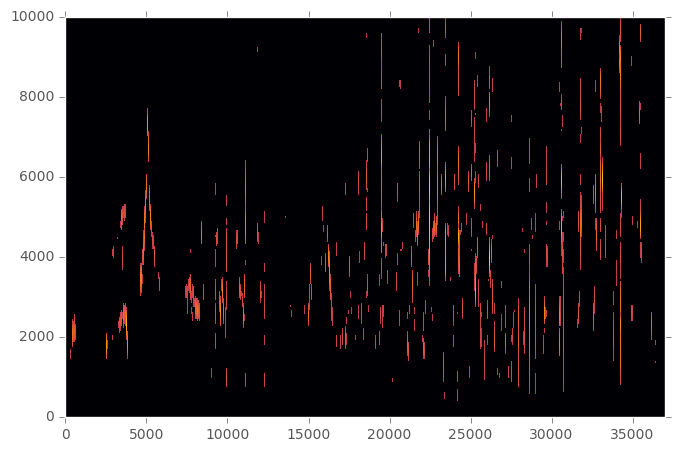

In [8]:
reload(sp)
#pattern
m_name = 'bos01_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m_id = et.stim_id(exp_par, m_name)

m = evt.Song(m_id, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
lfp_filter_pars = sp.make_butter_bandpass(s_f, lfp_filter_band[0], lfp_filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **song_spectr_pars)
ax = spec_obj.plot()

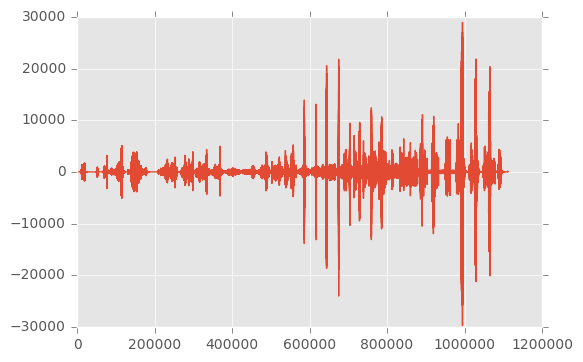

In [9]:
plt.plot(m_chunk.data[:, 0])

2017-03-30 18:27:42,803 bci.core.expstruct INFO     Overwriting parameter file; backup in experiment.par.yml.bk


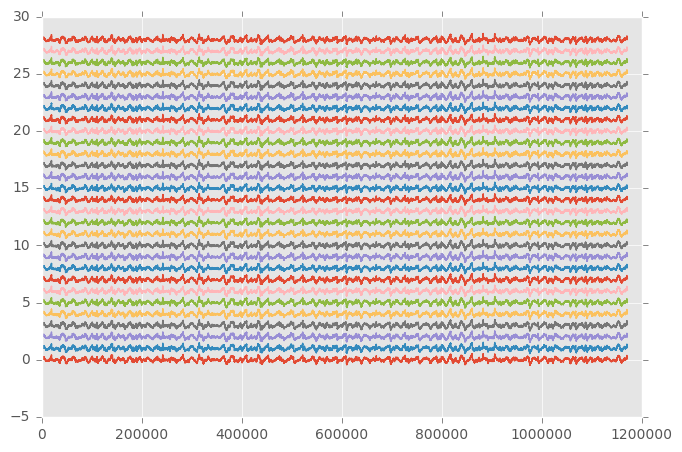

In [11]:
reload(st)
reload(et)
# bird = 'z030'
# sess = 'day-anesth_surface_2016-12-16_5'
# stim_sess = '001'

stim_name = 'bos01_tag'
fn = et.file_names(bird, sess)
exp_par = et.get_parameters(bird, sess)


stim_ev = get_evet(stim_name, bird, sess)
starts = stim_ev.get_start()
recs = stim_ev.get_rec()


i_bout = 18
#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
bad_chans = np.array([0, 25, 31])
neural_chans = np.delete(neural_chans, bad_chans)
#good_chans = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, neural_chans[-1]]
#neural_chans = neural_chans[good_chans]

before = 30000
after = 30000
rec = recs[i_bout]
dset = kwdf.get_data_set(et.open_kwd(bird, sess), rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, lfp_filter_pars)

lfp_frame.plot()

# update neural channels
#exp_par['channel_config']['neural_good']=[int(i) for i in neural_chans]
#et.update_parameters(exp_par, bird, sess)

2017-03-30 18:34:16,076 bci.core.expstruct INFO     probe file: /mnt/cube/earneodo/bci_zf/probes/lhs2005b2_0.prb
2017-03-30 18:34:16,237 root         INFO     Collecting 50 frames...
2017-03-30 18:34:16,238 root         INFO     Frame 0 ...
2017-03-30 18:34:25,610 root         INFO     Frame 10 ...
2017-03-30 18:34:28,572 root         INFO     Frame 20 ...
2017-03-30 18:34:31,498 root         INFO     Frame 30 ...
2017-03-30 18:34:34,431 root         INFO     Frame 40 ...
2017-03-30 18:34:42,319 root         WARNING  Frame out of bounds [130777316:131918608]


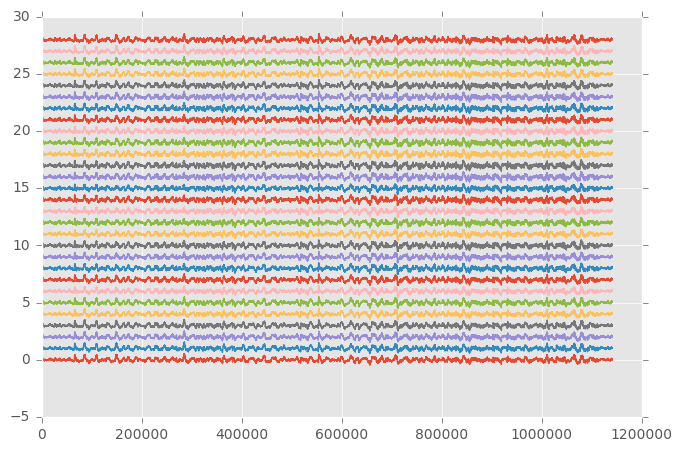

In [14]:
#bird = 'z030'
#sess = 'day-anesth_surface_2016-12-16_3'

#stim_name = 'bos_tag'
fn = et.file_names(bird, sess)
exp_par = et.get_parameters(bird, sess)
chan_map = load_site_chan_map(bird, sess)

try:
    neural_chans = np.array(exp_par['channel_config']['neural_good'])
    selected_neural_chans = neural_chans
except:
    pass

elec_pos = chan_positions(selected_neural_chans, chan_map)
elec_pos = elec_pos/np.max(elec_pos)
    
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': lfp_filter_pars, 
          'before_samp': 15000,
          'after_samp': 15000,
          'channels': neural_chans,
          'stim_chunk': m_chunk,
          'csd': {'steps': 30}
          }


all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)
viz_set['stim_chunk'] = stm_chunk
st.list_apply_filter(all_frames, sp.apply_butter_bandpass, lfp_filter_pars)
#st.list_apply_filter(all_frames, st.car, np.arange(neural_chans.size-1))

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

In [42]:
all_avg = st.sum_frames(all_frames)

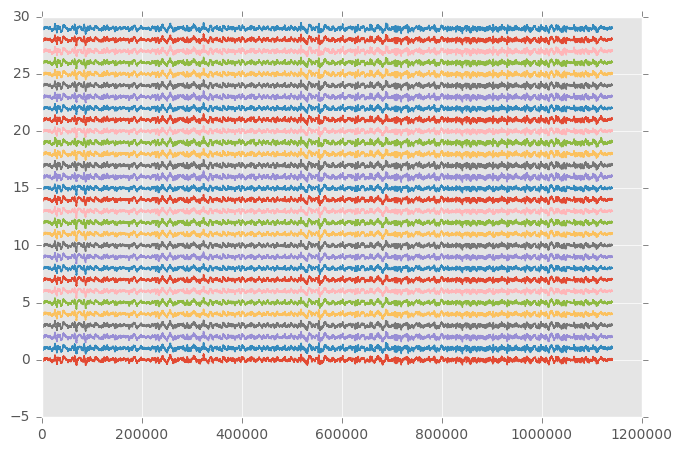

In [45]:
all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

In [57]:
all_frames[0]

<streamtools.streams.Chunk instance at 0x7f487f9a7320>

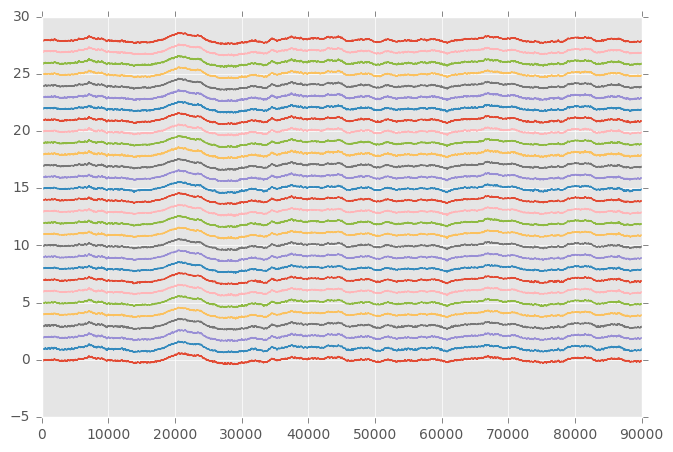

In [16]:
st.plot_array(all_frames[15].data[:90000,:]);

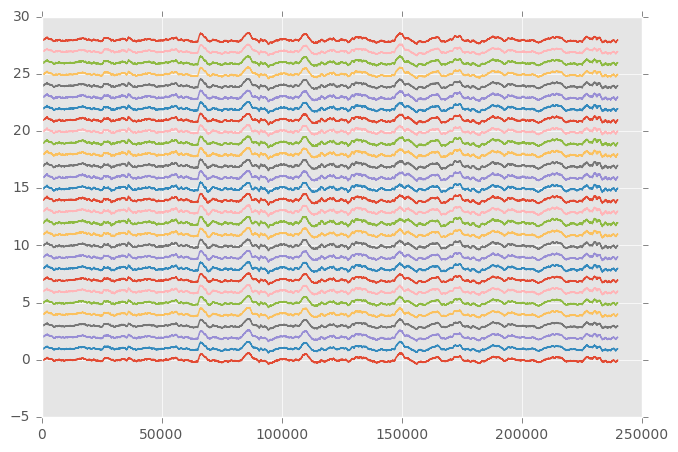

In [19]:
st.plot_array(all_avg[:120000*2,:]);

In [20]:
from __future__ import division
elec_pos = chan_positions(selected_neural_chans, chan_map)
elec_pos = elec_pos/np.max(elec_pos)
elec_pos

array([[ 0.16666667,  1.        ],
       [ 0.        ,  0.83333333],
       [ 0.33333333,  1.        ],
       [ 0.16666667,  0.66666667],
       [ 0.16666667,  0.83333333],
       [ 0.33333333,  0.66666667],
       [ 0.        ,  0.66666667],
       [ 0.16666667,  0.5       ],
       [ 0.        ,  0.5       ],
       [ 0.        ,  0.33333333],
       [ 0.16666667,  0.33333333],
       [ 0.        ,  0.16666667],
       [ 0.33333333,  0.33333333],
       [ 0.16666667,  0.16666667],
       [ 0.16666667,  0.        ],
       [ 0.5       ,  0.16666667],
       [ 0.33333333,  0.16666667],
       [ 0.66666667,  0.16666667],
       [ 0.5       ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 0.5       ,  0.33333333],
       [ 0.66666667,  0.5       ],
       [ 0.33333333,  0.5       ],
       [ 0.5       ,  0.66666667],
       [ 0.33333333,  0.83333333],
       [ 0.66666667,  0.66666667],
       [ 0.5       ,  0.83333333],
       [ 0.66666667,  0.83333333],
       [ 0.5       ,

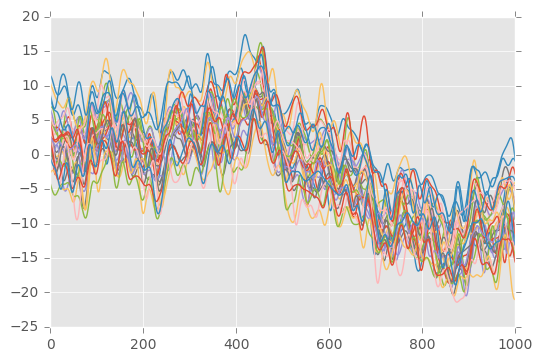

In [48]:
plt.plot(all_avg[63500:64500]);

In [36]:
len(all_frames)

75

In [31]:
all_frames[0].data.shape

(1141292, 30)

In [21]:
from pykCSD import pykCSD as cs
def plot_csd_point(in_data, sel_chans, ch_map, csd_pars={'gdX': 0.025, 'gdY': 0.025}):
    aux_elec_pos = chan_positions(sel_chans, ch_map)/100.
    aux_data = np.reshape(in_data, [-1, 1])
    print(elec_pos.shape)
    print(aux_data.shape)
    k_aux = cs.KCSD(aux_elec_pos, aux_data, csd_pars)
    k_aux.estimate_pots()
    k_aux.estimate_csd()

    k_aux.plot_all() 

def csd_all_points(in_data, in_elec_pos, csd_pars={'gdX': 0.025, 'gdY': 0.025}, step=1):
    # in_data is [n_samples, n_chans]
    n_samp, n_ch = in_data.shape
    csd_stack = []
    for i in np.arange(n_samp, step=step):
        if i % 3000 == 0:
            logger.info("Sample {0}/{1} ...".format(i, n_samp))
        k_i = cs.KCSD(in_elec_pos, np.reshape(in_data[i, :], [-1, 1]), csd_pars)
        k_i.estimate_pots()
        k_i.estimate_csd()
        csd_stack.append(k_i.pass_estimation()[0][:,:,0])
    logger.info('Done with all csd samples')
    return np.stack(csd_stack, axis=2)


#plot_csd_point(all_avg[60500,:], selected_neural_chans, chan_map)
viz_set['csd'] = {'steps': 30}
many_csd = csd_all_points(all_avg, elec_pos, step=viz_set['csd']['steps'])

2017-03-30 18:41:39,742 root         INFO     Sample 0/1141292 ...
2017-03-30 18:42:13,391 root         INFO     Sample 3000/1141292 ...
2017-03-30 18:42:46,433 root         INFO     Sample 6000/1141292 ...
2017-03-30 18:43:19,512 root         INFO     Sample 9000/1141292 ...
2017-03-30 18:43:53,541 root         INFO     Sample 12000/1141292 ...
2017-03-30 18:44:26,725 root         INFO     Sample 15000/1141292 ...
2017-03-30 18:44:59,792 root         INFO     Sample 18000/1141292 ...
2017-03-30 18:45:32,904 root         INFO     Sample 21000/1141292 ...
2017-03-30 18:46:05,907 root         INFO     Sample 24000/1141292 ...
2017-03-30 18:46:40,394 root         INFO     Sample 27000/1141292 ...
2017-03-30 18:47:13,518 root         INFO     Sample 30000/1141292 ...
2017-03-30 18:47:46,415 root         INFO     Sample 33000/1141292 ...
2017-03-30 18:48:19,284 root         INFO     Sample 36000/1141292 ...
2017-03-30 18:48:52,355 root         INFO     Sample 39000/1141292 ...
2017-03-30 18

In [28]:
et.mkdir_p(fn['folders']['proc'])
many_csd_file = os.path.join(fn['folders']['proc'], 'csd_avg.npy')
np.save(many_csd_file, many_csd)

In [29]:
many_csd.shape

(41, 27, 38044)

In [34]:
viz_set

{'after_samp': 15000,
 'before_samp': 15000,
 'channels': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]),
 'csd': {'steps': 30},
 'filter_pars': {'hi_cut': 1250,
  'hp_a': array([ 1.        , -3.99945271,  5.99835827, -3.99835842,  0.99945286]),
  'hp_b': array([ 0.99972639, -3.99890557,  5.99835835, -3.99890557,  0.99972639]),
  'lo_cut': 1,
  'lp_a': array([ 1.        , -3.31680791,  4.17424555, -2.35740278,  0.50337536]),
  'lp_b': array([ 0.00021314,  0.00085255,  0.00127883,  0.00085255,  0.00021314])},
 'stim_chunk': <streamtools.streams.Chunk instance at 0x7fc5894134d0>,
 'stim_sess': '001'}

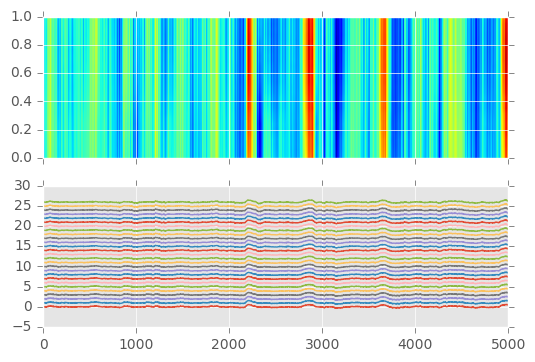

In [39]:
csd_arr = many_csd[:,:, :int(viz_set['before_samp']*10/viz_set['csd']['steps'])]
total_t = csd_arr.shape[2]
f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(csd_arr[2, :, :], extent=[0,total_t,0,1], aspect='auto')
st.plot_array(csd_arr[2, :, :].T, ax=axarr[1]);

In [310]:
# gather csd for all the frames
all_frames_csd = [csd_all_points(fr.data, elec_pos, step=viz_set['csd']['steps']) for fr in all_frames]

2017-02-01 18:44:04,484 root         INFO     Sample 0/59951 ...
2017-02-01 18:44:39,596 root         INFO     Sample 3000/59951 ...
2017-02-01 18:45:14,377 root         INFO     Sample 6000/59951 ...
2017-02-01 18:45:48,528 root         INFO     Sample 9000/59951 ...
2017-02-01 18:46:22,555 root         INFO     Sample 12000/59951 ...
2017-02-01 18:46:57,162 root         INFO     Sample 15000/59951 ...
2017-02-01 18:47:31,966 root         INFO     Sample 18000/59951 ...
2017-02-01 18:48:06,256 root         INFO     Sample 21000/59951 ...
2017-02-01 18:48:39,673 root         INFO     Sample 24000/59951 ...
2017-02-01 18:49:12,351 root         INFO     Sample 27000/59951 ...
2017-02-01 18:49:45,618 root         INFO     Sample 30000/59951 ...
2017-02-01 18:50:19,998 root         INFO     Sample 33000/59951 ...
2017-02-01 18:50:53,371 root         INFO     Sample 36000/59951 ...
2017-02-01 18:51:28,010 root         INFO     Sample 39000/59951 ...
2017-02-01 18:52:01,184 root         INFO

In [316]:
all_frames_csd[0].shape
all_csd_arr = np.stack(all_frames_csd, axis=3)

In [317]:
all_csd_arr.shape

(41, 27, 1999, 74)

In [40]:
from bci.core.file import file_functions as ff
reload(ff)

<module 'bci.core.file.file_functions' from '/mnt/cube/earneodo/repos/swissknife/bci/core/file/file_functions.pyc'>

In [323]:
csd_set = {'bird' : bird,
           'sess' : sess,
           'stim' : stim_name,
           'viz': viz_set,
           'csd': all_csd_arr}

fname = '{0}_{1}:{2}_csd.pkl'.format(bird, sess, stim_name)
fold = os.path.join(fn['locations']['experiment'], 'analysis', 'csd')

et.mkdir_p(fold)
ff.save_obj(csd_set, os.path.join(fold, fname))

total_t = all_csd_arr.shape[2]
vmin= np.min(all_csd_arr)
vmax=np.min(all_csd_arr)

In [324]:
avg_csd = np.mean(all_csd_arr, axis=3)

In [318]:
viz_set

{'after_samp': 15000,
 'before_samp': 15000,
 'channels': array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 29, 30,
        32]),
 'csd': {'steps': 30},
 'filter_pars': {'hi_cut': 1250,
  'hp_a': array([ 1.        , -3.99945271,  5.99835827, -3.99835842,  0.99945286]),
  'hp_b': array([ 0.99972639, -3.99890557,  5.99835835, -3.99890557,  0.99972639]),
  'lo_cut': 1,
  'lp_a': array([ 1.        , -3.31680791,  4.17424555, -2.35740278,  0.50337536]),
  'lp_b': array([ 0.00021314,  0.00085255,  0.00127883,  0.00085255,  0.00021314])},
 'stim_chunk': <streamtools.streams.Chunk instance at 0x7f144a16a2d8>,
 'stim_sess': '001'}

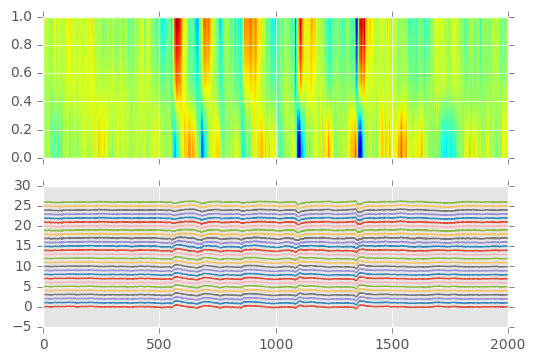

In [333]:
reload(st)
f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(avg_csd[2, :, :], extent=[0,total_t,0,1], aspect='auto')
st.plot_array(avg_csd[2, :, :].T, ax=axarr[1]);

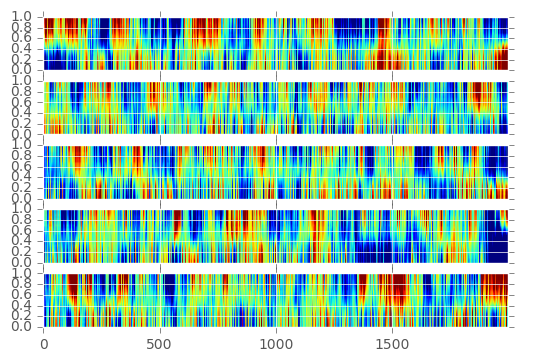

In [347]:
row = 2
f, axarr = plt.subplots(5, sharex=True)
for i_fr in np.arange(all_csd_arr.shape[3])[:5]:
    axarr[i_fr].imshow(all_csd_arr[row, :, :, i_fr], extent=[0,total_t,0,1], 
                       vmin=-100, 
                       vmax=120, 
                       aspect='auto',
                      cmap = 'jet')

In [331]:
total_t

4998.366666666667

In [326]:
for i_fr in 

(41, 27, 1999)

In [288]:
stchn.data.shape[0]+120000

149951

In [285]:
many_csd.shape[2]*30

149970

(<matplotlib.figure.Figure at 0x7f146c3d5d50>,
 <matplotlib.axes._axes.Axes at 0x7f146c436b10>)

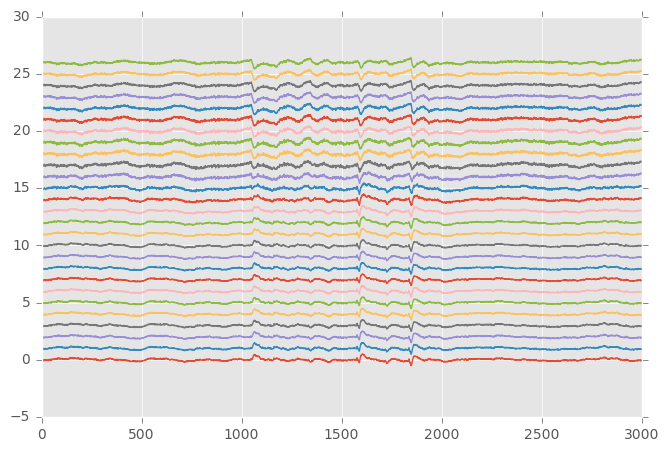

In [60]:
st.plot_array(many_csd[2, :, :].T)

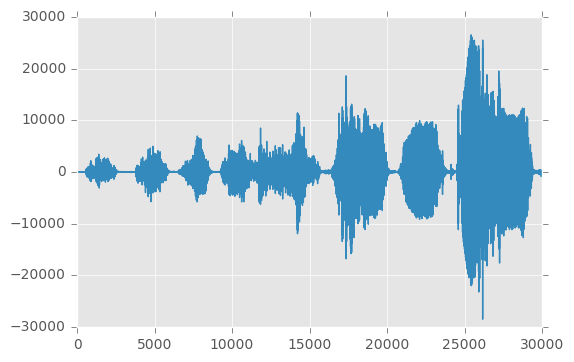

In [269]:
plt.plot(many_csd[2, 2, :].T);
plt.plot(stchn.data/);

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [42]:
viz_set['stim_chunk'].samples


1111292

In [293]:
viz_set = {'stim_sess': '001', 
          'filter_pars': lfp_filter_pars, 
          'before_samp': 15000,
          'after_samp': 15000,
          'channels': neural_chans,
          'stim_chunk': stm_chunk,
          'csd': {'steps': 30}
          }

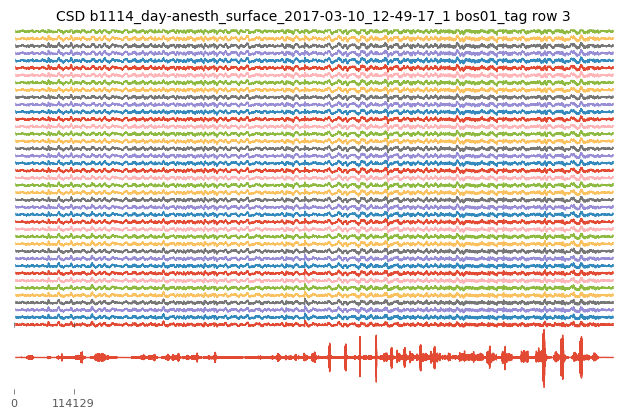

KeyError: u'ffmpeg'

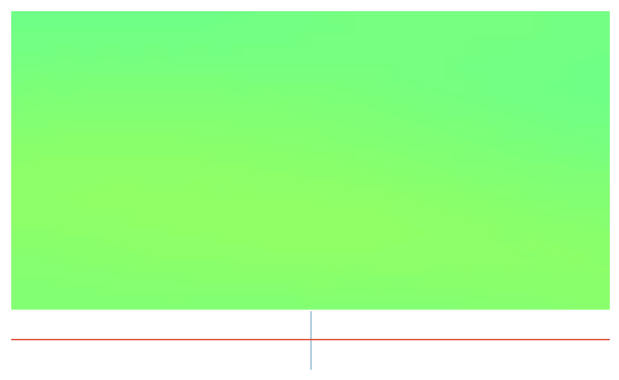

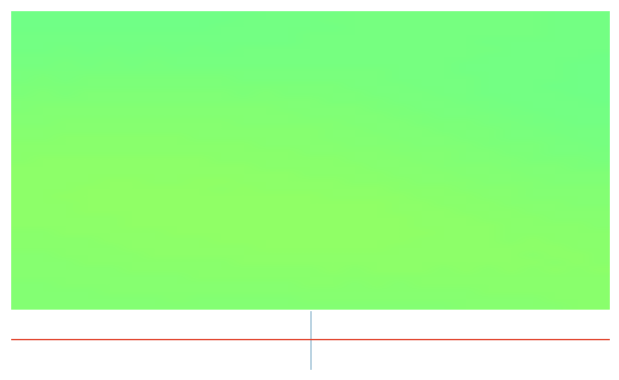

In [47]:
import matplotlib.patches as patches

class CsdViewer():
    def __init__(self, csd_data, vis_pars):
        self.csd = csd_data
        self.stim_chk = vis_pars['stim_chunk']
        self.stim_data = None
        self.v_p = vis_pars
        self.step_samples = vis_pars['csd']['steps']        
        self.step = 0
        self.hws = 7500 #half_window_size
        self.fig_width = 1
        self.fig = None
        self.fig_ax = {}
        self.fig_plt = {}
        self.disp_chnk = None
        self.stim_patch = None
        self.anim = None
        self.v_bounds = None
        self.select_sources = np.arange(csd_data.shape[1])
        self.start = 0
        self.end = 0
        self.cb = None
    
    
    def init_fig(self):
        self.fig = plt.figure()

        self.fig_ax['csd'] = self.fig.add_axes([0.0,.2,self.fig_width-.0,0.75])
        self.fig_ax['stim'] = self.fig.add_axes([0.0,0.05,self.fig_width-.0,0.15])
        
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.tick_params(axis='both', which='minor', labelsize=6)
            ax.patch.set_alpha(0)
            
        self.v_bounds = [np.min(self.csd[:,:,:]), np.max(self.csd[:,:,:])]

    
    def init_movie(self):
        self.init_fig()
        self.init_stim()
        self.init_csd()
        self.update_csd()
        self.update_stim()
    
    
    
    def init_stim(self):
        self.stim_data = np.hstack([np.zeros(self.v_p['before_samp'] + self.hws), 
                        self.stim_chk.data[:, 0],
                        np.zeros(self.v_p['after_samp'] + self.hws)])
#         self.stim_data = np.hstack([ 
#                         self.stim_chk.data[:, 0],
#                         np.zeros(self.v_p['after_samp'] + self.hws)])
        
         
        min_stim = np.min(self.stim_data)
        max_stim = np.max(self.stim_data)
        ax=self.fig_ax['stim']
        ax.set_xlim([np.min(self.stim_data), np.max(self.stim_data)])
        ax.set_xlim((0, 2*self.hws))
        ax.set_ylim((min_stim, max_stim))
        
#         self.stim_patch = patches.Rectangle((0, min_stim), self.step_samples, 
#                                        min_stim + max_stim, alpha=0.6)
        self.stim_patch = patches.Rectangle((self.hws, min_stim), 
                                            self.step_samples, np.diff([min_stim, max_stim]), 
                                            alpha=.4)
    
        self.fig_plt['stim'],  = self.fig_ax['stim'].plot([],[])
        self.fig_plt['stim'].set_data([],[])
        self.fig_plt['stim_bar'] = self.fig_ax['stim'].add_patch(self.stim_patch)

        
    def init_csd(self):
        self.fig_plt['csd'] = self.fig_ax['csd'].imshow(self.csd[:,:,0], 
                                         aspect='auto', 
                                         animated=True, 
                                         vmin= self.v_bounds[0], 
                                         vmax= self.v_bounds[1])

    def update_stim(self):    
        ax = self.fig_ax['stim']
        start = self.step*self.step_samples
        self.disp_chnk = self.stim_data[start: start + 2*self.hws]
        self.fig_plt['stim'].set_data(np.arange(self.disp_chnk.size), self.disp_chnk)
        self.fig_plt['stim_bar'] = self.fig_ax['stim'].add_patch(self.stim_patch)

    def update_csd(self):
        ax = self.fig_ax['csd']
        im = self.fig_plt['csd']
        im.set_array(self.csd[:,:,self.step])
        return im,

    def update_fig(self, step):
        self.step = step
        self.update_stim()
        self.update_csd()
        return self.fig_plt['stim'],

    def animate(self, step = 10):
        self.init_movie()
        self.anim = animation.FuncAnimation(self.fig, self.update_fig, 
                                       np.arange(self.csd.shape[2], step=step), blit=True)
        #HTML(self.anim.to_html5_video())
    
    def set_v_bounds(self, v_min, v_max):
        self.v_bounds = [v_min, v_max]
        
    def plot_sources(self, heatmap=True, start=0, end=None, sources=None):
        s_ax = self.fig_ax['stim']
        c_ax = self.fig_ax['csd']


        self.start = start
        if end is None:
            self.end = self.v_p['before_samp'] + self.stim_chk.samples + self.v_p['after_samp']
        else:
            self.end = end
    
        all_csd = np.reshape(self.csd,(-1, self.csd.shape[2]))
        
        if sources is not None:
            self.select_sources = sources

        csd_plot = all_csd[self.select_sources, 
                           np.int(self.start/self.step_samples) : np.int(self.end/self.step_samples)]
        if heatmap:
            self.fig_plt['csd'] = self.fig_ax['csd'].imshow(csd_plot, 
                                                            extent=[self.start,self.end,0,1],
                                                            aspect='auto',
                                                            vmin= self.v_bounds[0], 
                                                            vmax= self.v_bounds[1])
            cb = plt.colorbar(self.fig_plt['csd'], 
                         ax=s_ax, 
                         orientation='horizontal',
                         fraction=0.1,
                        shrink = 1)
            
            self.cb = cb
            
            #cb.tick_params(axis='both', which='major', labelsize=8)
            self.cb.ax.tick_params(axis='both', which='major', labelsize=6)
            #self.fig_plt['csd'].tick_params(axis='both', which='minor', labelsize=6)
            
        else:
            self.fig_plt['csd'] = st.plot_array(csd_plot.T, ax=self.fig_ax['csd'])
            
            
        #the stimulus
        all_stim = np.hstack([np.zeros(self.v_p['before_samp']), 
                        self.stim_chk.data[:, 0],
                        np.zeros(self.v_p['after_samp'])])
        
        min_stim = np.min(all_stim)
        max_stim = np.max(all_stim)
        ax=self.fig_ax['stim']
        ax.set_xlim([np.min(self.stim_data), np.max(self.stim_data)])
        ax.set_xlim((self.start, self.end))
        ax.set_ylim((min_stim, max_stim))
        self.fig_plt['stim'],  = self.fig_ax['stim'].plot([],[])
        self.fig_plt['stim'].set_data(np.arange(self.start, self.end), all_stim[self.start:self.end])
        s_ax.xaxis.set_ticks([self.start, np.int((self.end - self.start)*0.1) + self.start])
    
    def plot_save(self, file_path):
        self.fig.savefig(file_path)
        
    def plot_set_title(self, title):
        self.fig_ax['csd'].set_title(title, fontsize=10)
        
    

cad_v = CsdViewer(many_csd, viz_set)

cad_v.init_fig()
#cad_v.plot_sources(start=25000, end=65000, heatmap=True, sources=np.arange(28*3, 28*4))

# pot a row
csd_row = 3
csd_cols, csd_rows = cad_v.csd[:,:,0].shape

fig_label = 'CSD {0}_{1} {2} row {3}'.format(bird, sess, stim_name, csd_row)
fig_name = 'csd_trc_{0}_{1}_{2}.pdf'.format(bird, sess, stim_name)
fig_path = os.path.join(fn['folders']['ss'], fig_name)

cad_v.set_v_bounds(-70, 80)
cad_v.plot_sources(start=0, end=None, heatmap=False, 
                   sources=np.arange(csd_row, cad_v.csd[:,:,0].size, csd_rows))
cad_v.plot_set_title(fig_label)
#cad_v.fig.tight_layout()
cad_v.plot_save(fig_path)
# cad_v.fig.set_label(fig_label)
# cad_v.fig.savefig(fig_path)

plt.show()
cad_v.init_movie()
cad_v.update_fig(5)
anim = animation.FuncAnimation(cad_v.fig, cad_v.update_fig, np.arange(cad_v.csd.shape[2], step=10), blit=True)
cad_v.animate()
HTML(cad_v.anim.to_html5_video())

KeyError: u'ffmpeg'

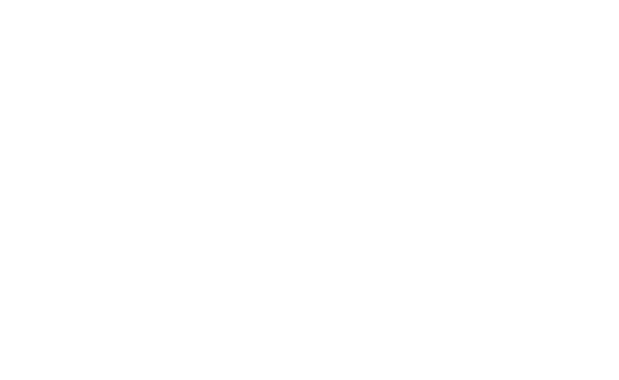

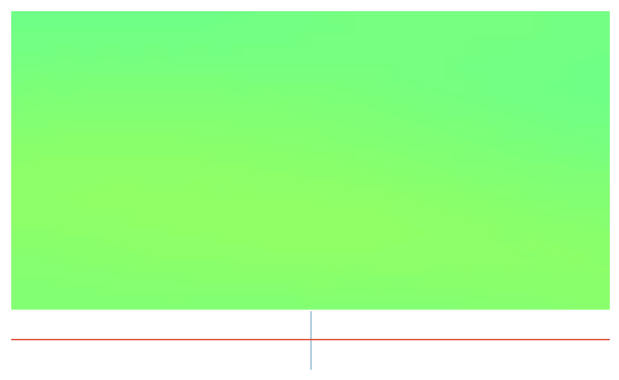

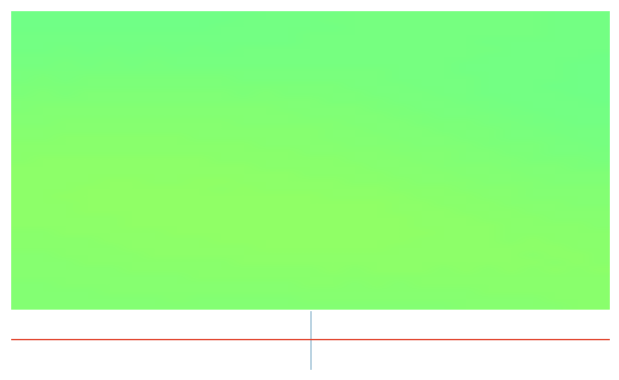

In [45]:
from matplotlib import animation, rc
from IPython.display import HTML
cad_v = CsdViewer(many_csd, viz_set)

cad_v.init_fig()
cad_v.init_movie()
cad_v.update_fig(5)
anim = animation.FuncAnimation(cad_v.fig, cad_v.update_fig, np.arange(cad_v.csd.shape[2], step=10), blit=True)
cad_v.animate()
HTML(cad_v.anim.to_html5_video())

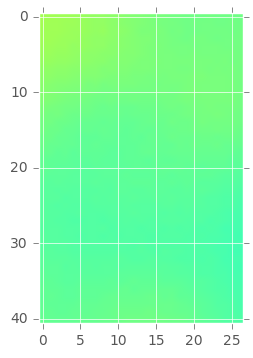

In [353]:
plt.imshow(avg_csd[:,:, 30], vmin=-70, vmax=70)

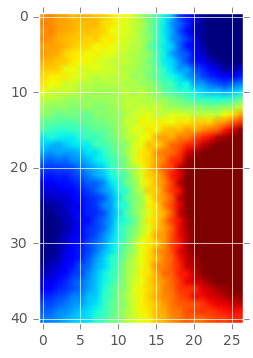

In [355]:
plt.imshow(avg_csd[:,:, 1100], vmin=-70, vmax=70)

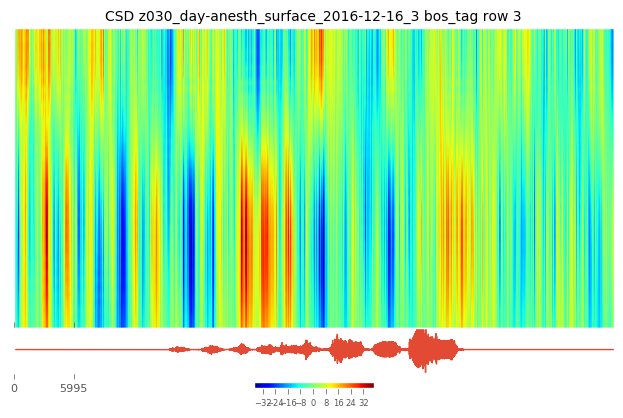

In [337]:
cad_v = CsdViewer(many_csd, viz_set)

cad_v.init_fig()
#cad_v.plot_sources(start=25000, end=65000, heatmap=True, sources=np.arange(28*3, 28*4))

# pot a row
csd_row = 3
csd_cols, csd_rows = cad_v.csd[:,:,0].shape

fig_label = 'CSD {0}_{1} {2} row {3}'.format(bird, sess, stim_name, csd_row)
fig_name = 'csd_{0}_{1}_{2}.pdf'.format(bird, sess, stim_name)
fig_path = os.path.join(fn['folders']['ss'], fig_name)

cad_v.plot_sources(start=0, end=None, heatmap=True, 
                   sources=np.arange(csd_row, cad_v.csd[:,:,0].size, csd_rows))
cad_v.plot_set_title(fig_label)
#cad_v.fig.tight_layout()
#cad_v.plot_save(fig_path)
# cad_v.fig.set_label(fig_label)
# cad_v.fig.savefig(fig_path)

plt.show()

In [295]:
cad_v.csd.shape

(41, 27, 4999)

In [249]:
cad_v.cb.ax.tick_params(axis='both', which='major', labelsize=8)

In [195]:
csd_row = 3

fig_label = 'CSD {0}_{1}_{2} row {3}'.format(bird, sess, stim_name, csd_row)
fig_name = 'csd_{0}_{1}_{2}.pdf'.format(bird, sess, stim_name)
fig_path = os.path.join(fn['folders']['ss'], fig_name)

cad_v.fig.set_label(fig_label)
cad_v.fig.savefig(fig_path)

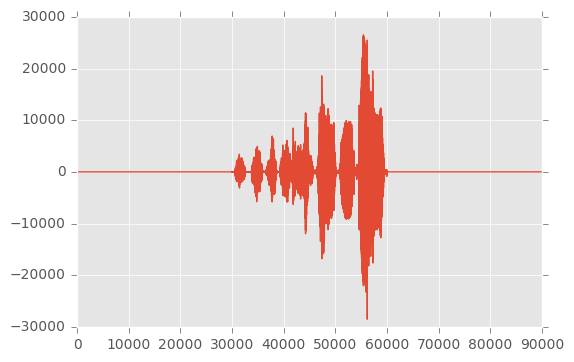

In [101]:
a_s = np.hstack([np.zeros(cad_v.v_p['before_samp']), 
                        cad_v.stim_chk.data[:, 0],
                        np.zeros(cad_v.v_p['after_samp'])])
plt.plot(a_s[])

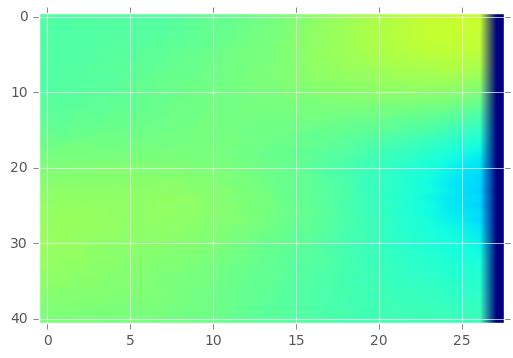

In [41]:
fig = plt.figure()

im = plt.imshow(new_csd[:,:,0], aspect='auto', animated=True, vmin=np.min(new_csd[:,:,:]), vmax=np.max(new_csd[:,:,:]))

def updatefig(t):
    im.set_array(new_csd[:,:,t])
    return im,

ani = animation.FuncAnimation(fig, updatefig, np.arange(n_steps, step=10), blit=True)
HTML(ani.to_html5_video())

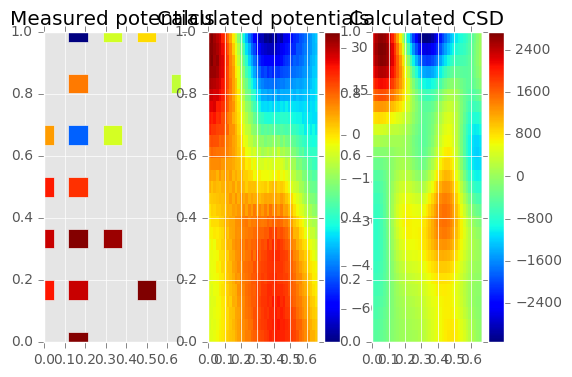

In [18]:
elec_pos = chan_positions(selected_neural_chans, chan_map)/1200.
csd_pars = {'gdX': 0.025, 'gdY': 0.025}

pots = np.reshape(all_avg[31000,:], [-1, 1])
k = cs.KCSD(elec_pos, pots, csd_pars)

k.estimate_pots()
k.estimate_csd()

k.plot_all()

2017-01-11 08:53:55,094 root         INFO     Collecting 75 frames...
2017-01-11 08:53:55,096 root         INFO     Frame 0 ...
2017-01-11 08:53:55,393 root         INFO     Frame 10 ...
2017-01-11 08:53:55,624 root         INFO     Frame 20 ...
2017-01-11 08:53:55,847 root         INFO     Frame 30 ...
2017-01-11 08:53:56,069 root         INFO     Frame 40 ...
2017-01-11 08:53:56,281 root         INFO     Frame 50 ...
2017-01-11 08:53:56,472 root         INFO     Frame 60 ...
2017-01-11 08:53:56,663 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898
4993.86666667
fcut_plot 6.90775527898


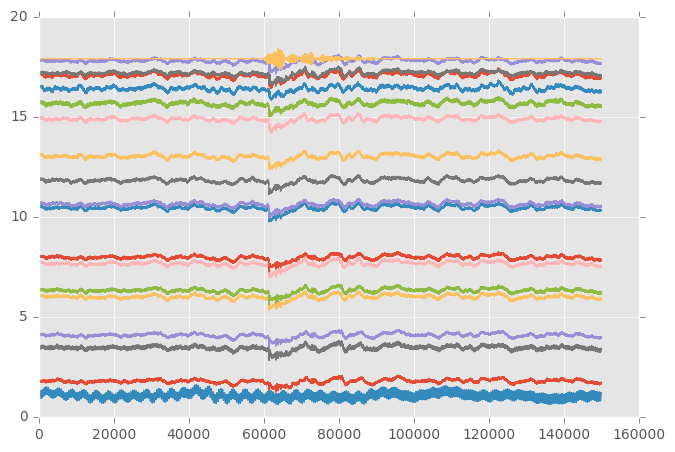

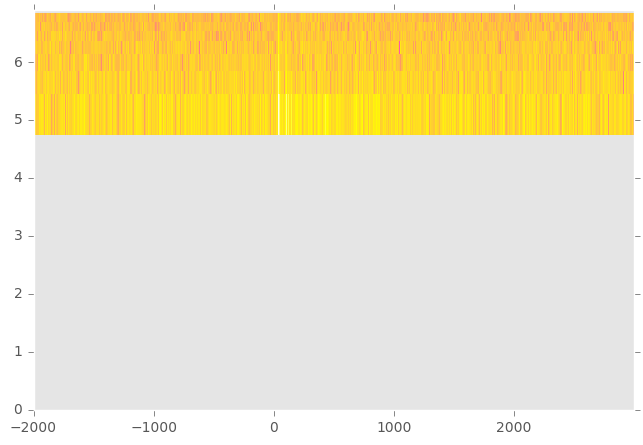

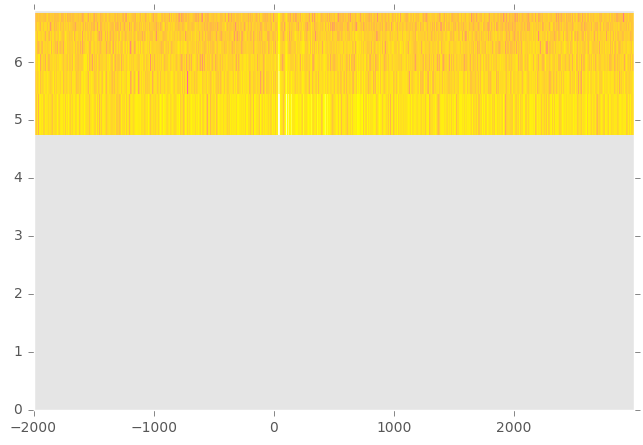

In [7]:
sess = 'day-anesth_surface_2016-12-16_3'
stim_name = 'bos_rev_tag'
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': filter_pars, 
          'before_samp': 60000,
          'after_samp': 60000,
          'channels': neural_chans}

fn = et.file_names(bird, sess)

all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
chan = 2
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

In [14]:
all_frames[0].data[:, 1]

array([  87.,   93.,  130., ...,  106.,  105.,  133.])

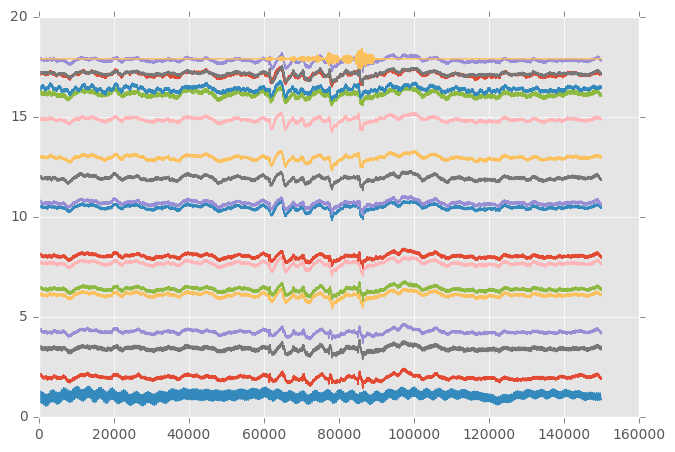

In [48]:
stim_name = 'bos_tag'
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

2017-01-10 13:49:29,912 root         INFO     Collecting 75 frames...
2017-01-10 13:49:29,913 root         INFO     Frame 0 ...
2017-01-10 13:49:31,789 root         INFO     Frame 10 ...
2017-01-10 13:49:33,070 root         INFO     Frame 20 ...
2017-01-10 13:49:34,357 root         INFO     Frame 30 ...
2017-01-10 13:49:35,859 root         INFO     Frame 40 ...
2017-01-10 13:49:37,221 root         INFO     Frame 50 ...
2017-01-10 13:49:38,511 root         INFO     Frame 60 ...
2017-01-10 13:49:39,690 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898


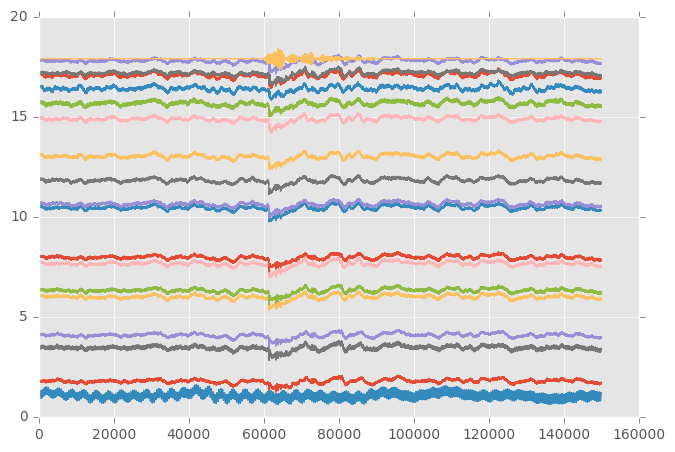

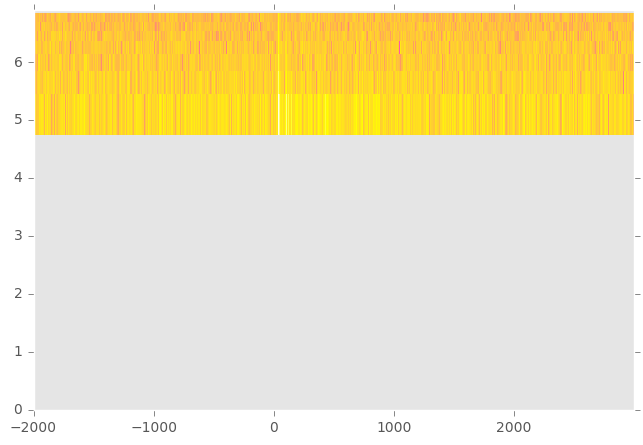

In [42]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='bos_rev_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

2017-01-10 13:46:39,464 root         INFO     Collecting 70 frames...
2017-01-10 13:46:39,466 root         INFO     Frame 0 ...
2017-01-10 13:46:40,974 root         INFO     Frame 10 ...
2017-01-10 13:46:42,287 root         INFO     Frame 20 ...
2017-01-10 13:46:43,514 root         INFO     Frame 30 ...
2017-01-10 13:46:45,058 root         INFO     Frame 40 ...
2017-01-10 13:46:46,479 root         INFO     Frame 50 ...
2017-01-10 13:46:47,457 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9db7dc650>,
 <matplotlib.axes._axes.Axes at 0x7fd9db30fd90>)

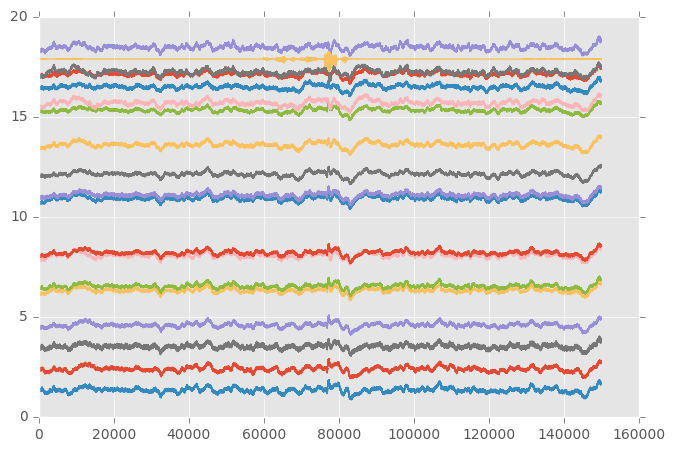

In [37]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='con_syn_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

2017-01-10 10:52:27,640 root         INFO     Collecting 70 frames...
2017-01-10 10:52:27,642 root         INFO     Frame 0 ...
2017-01-10 10:52:27,976 root         INFO     Frame 10 ...
2017-01-10 10:52:28,146 root         INFO     Frame 20 ...
2017-01-10 10:52:28,316 root         INFO     Frame 30 ...
2017-01-10 10:52:28,536 root         INFO     Frame 40 ...
2017-01-10 10:52:28,728 root         INFO     Frame 50 ...
2017-01-10 10:52:28,913 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9dbc58b10>,
 <matplotlib.axes._axes.Axes at 0x7fd9d1d3ab90>)

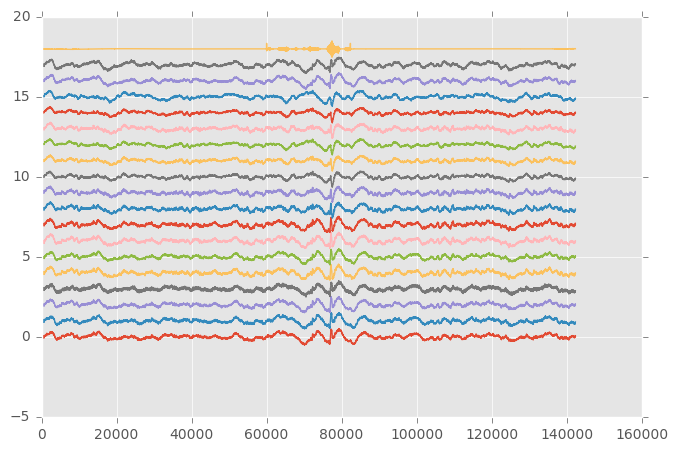

In [10]:
logger.setLevel(logging.INFO)
before = 60000
after = 60000

all_frames, all_starts, all_recs = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

nothing = st.list_apply_filter(all_frames, sp.apply_butter_bandpass, filter_pars)

# average across all frames
reload(st)
all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

1452.0
fcut_plot 5.70378247466


/mnt/cube/earneodo/repos/swissknife/streamtools/spectral.py:78: RuntimeWarning: divide by zero encountered in log
  f_plot = np.log(f) if log_f else f


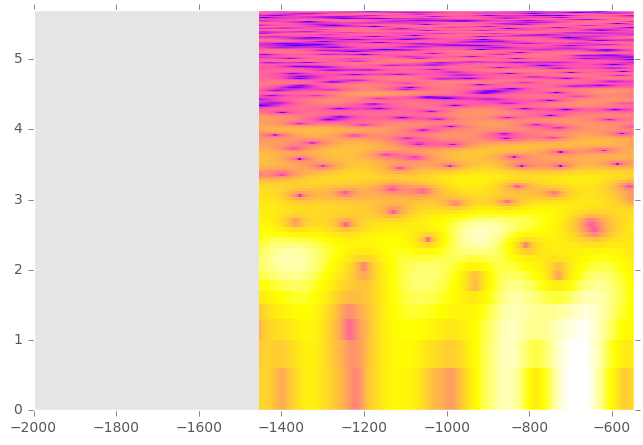

In [360]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')


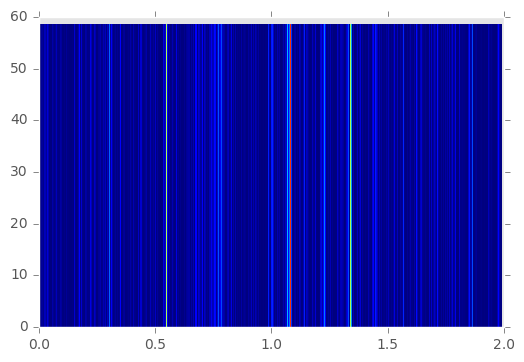

In [375]:
x = all_avg[:,chan]
f_max = 100

f, t, sxx = spectrogram(x, fs=30000, nperseg=512, noverlap=511)
plt.pcolormesh(t, f[f<f_max], sxx[f<f_max, :])

In [369]:
f

array([     0.    ,    117.1875,    234.375 ,    351.5625,    468.75  ,
          585.9375,    703.125 ,    820.3125,    937.5   ,   1054.6875,
         1171.875 ,   1289.0625,   1406.25  ,   1523.4375,   1640.625 ,
         1757.8125,   1875.    ,   1992.1875,   2109.375 ,   2226.5625,
         2343.75  ,   2460.9375,   2578.125 ,   2695.3125,   2812.5   ,
         2929.6875,   3046.875 ,   3164.0625,   3281.25  ,   3398.4375,
         3515.625 ,   3632.8125,   3750.    ,   3867.1875,   3984.375 ,
         4101.5625,   4218.75  ,   4335.9375,   4453.125 ,   4570.3125,
         4687.5   ,   4804.6875,   4921.875 ,   5039.0625,   5156.25  ,
         5273.4375,   5390.625 ,   5507.8125,   5625.    ,   5742.1875,
         5859.375 ,   5976.5625,   6093.75  ,   6210.9375,   6328.125 ,
         6445.3125,   6562.5   ,   6679.6875,   6796.875 ,   6914.0625,
         7031.25  ,   7148.4375,   7265.625 ,   7382.8125,   7500.    ,
         7617.1875,   7734.375 ,   7851.5625,   7968.75  ,   808

In [366]:
sxx.shape

(129, 267)

3452.0
fcut_plot 5.70378247466


(<matplotlib.figure.Figure at 0x7fa479e066d0>,
 <matplotlib.axes._axes.Axes at 0x7fa48bc79850>)

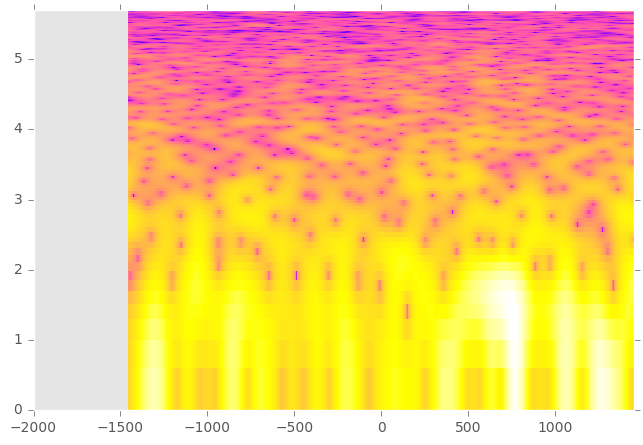

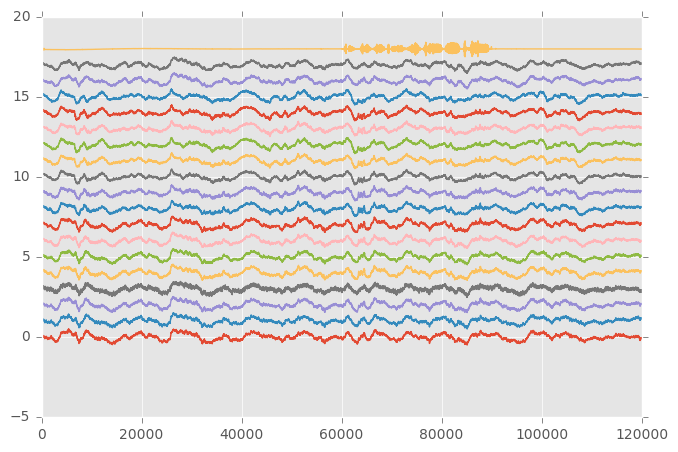

In [99]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
first_avg.plot()

In [31]:
f_cut = 70
n_window = 2048*8
n_overlap = n_window-8

response_spectrogram = spectrogram(first_avg.data[:, 8], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*30), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

NameError: name 'sigma' is not defined

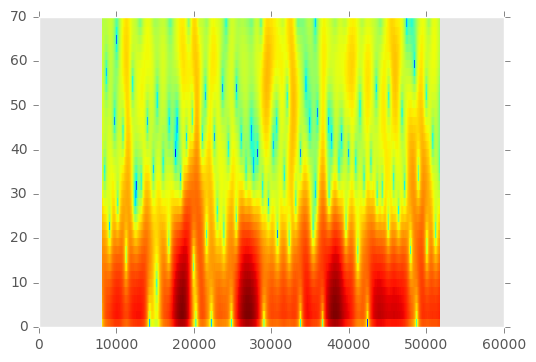

In [14]:
response_spectrogram = spectrogram(lfp_frame.data[:, 6], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [26]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


spectr_stack = []

for ch in range(n_chans):
    print ch
    for i_trial in range(n_trials):
        start = starts[i_trial]
        one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
        lfp[:, i_trial, :] = one_frame.data
        this_spectrogram = spectrogram(one_frame.data[:, ch], s_f, 
                                      nperseg = n_window, 
                                      noverlap= n_overlap, 
                                      window = sg.gaussian(n_window, sigma*50), 
                                      scaling='density')
        spectr[i_trial, :, :] = (this_spectrogram[2])
    
    spectr_stack.append(spectr)
    
#all_spectra = np.stack(spectr_stack, axis=0)

0
1
2
3
4
5
6
7


MemoryError: 

In [66]:
all_spectra = np.stack(spectr_stack, axis=0)

MemoryError: 

In [52]:
spectr_stack[0].shape

(74, 8193, 3890)

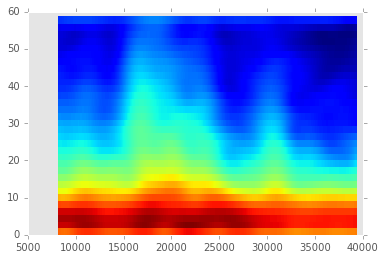

In [28]:
f_cut = 60
ch = 2
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

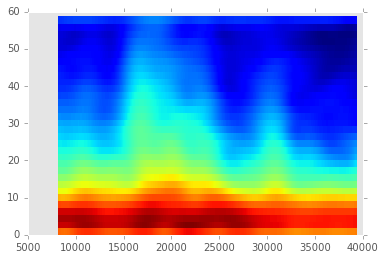

In [34]:
f_cut = 60
ch = 4
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

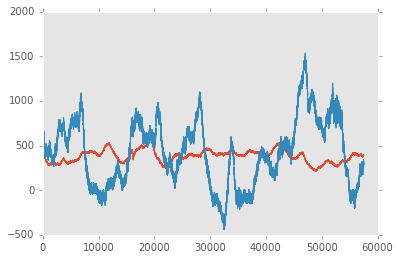

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

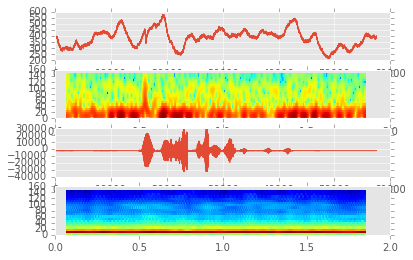

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


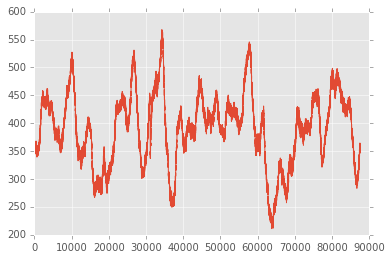

In [96]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))

In [24]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec][:-1]):
        print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


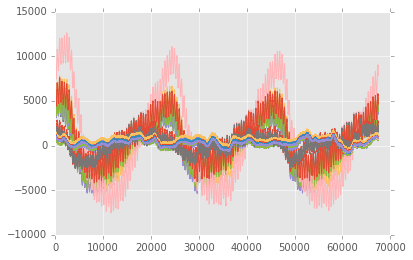

In [10]:
plt.plot(sup_lfp[:,7,:].T)

In [37]:
np.unique(recs)

array([0])

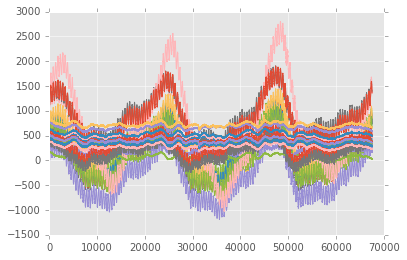

In [11]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape
plt.plot(trial_mean.T)

In [15]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape

(31, 67535)

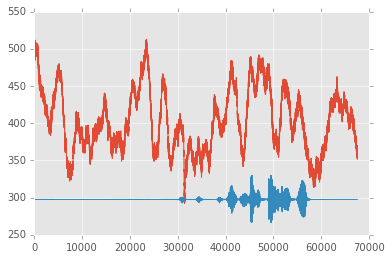

In [38]:
plt.plot(trial_mean[30,:])
plt.plot(lfp_frame.data[:,31]/1000. + 300)

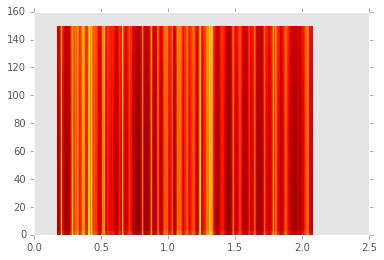

In [46]:
f_cut = 150
n_window = 1024*10
n_overlap = n_window - 1
response_spectrogram = spectrogram(trial_mean[30,:], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [ ]:
scipy.io.wavfile.write(filename, rate, data)

In [49]:
wavfile.write('one_channel.wav', 30000, trial_mean[30,:].astype(np.int16))


In [48]:
pwd

u'/mnt/cube/earneodo/repos/ephysflow'